In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cnv_profile import CNV_Profile
from plot_cnv_profile import plot_acr_static
import swifter
import natsort


## Get cytobands

In [2]:
import sys
sys.path.append('/home/cmesser/HapASeg')
from hapaseg.utils import parse_cytoband

Could not load reference genome!


Cannot find path to gnomAD index; gnomAD functionality disabled.


In [3]:
cband = pd.read_csv('../cnv_data/cytoBand.hg38.txt', sep = "\t", names = ["chr", "start", "end", "band", "stain"])
cband

,chr,start,end,band,stain
0,chr1,0,2300000,p36.33,gneg
1,chr1,2300000,5300000,p36.32,gpos25
2,chr1,5300000,7100000,p36.31,gneg
3,chr1,7100000,9100000,p36.23,gpos25
4,chr1,9100000,12500000,p36.22,gneg
...,...,...,...,...,...
857,chrY,12400000,17100000,q11.221,gpos50
858,chrY,17100000,19600000,q11.222,gneg
859,chrY,19600000,23800000,q11.223,gpos50
860,chrY,23800000,26600000,q11.23,gneg


In [ ]:
centromere_df = parse_cytoband('../cnv_data/cytoBand.hg38.txt')
centromere_df.loc[centromere_df[centromere_df['start'] == 0].index, 'arm'] = 'p'
centromere_df.loc[centromere_df[centromere_df['start'] != 0].index, 'arm'] = 'q'

centromere_spec_df = centromere_df.set_index(['chr', 'arm']).unstack()[[('start', 'q'), ('end', 'p')]]
centromere_spec_df['avg'] = centromere_spec_df.mean(axis=1).astype(int)
centromere_spec_df['list'] = centromere_spec_df.apply(lambda x: [int(x[('end', 'p')]), int(x[('start', 'q')])], axis=1)
centromere_spec_df.columns = centromere_spec_df.columns.droplevel(1)
centromere_spec_df.index = centromere_spec_df.index.map(str)

In [ ]:
centromere_avg_center = centromere_spec_df.to_dict()['avg']
centromere_span_center = centromere_spec_df.to_dict()['list']

In [ ]:
centromere_spec_df[['start', 'end', 'avg']].to_csv('./test/simulation/centromeres.hg38.txt', sep='t', index=True)


## Get Simulated CNV Profile

In [ ]:
import importlib
import cnv_profile
importlib.reload(cnv_profile)
from cnv_profile import CNV_Profile

In [ ]:
default_profile = CNV_Profile(num_subclones=3, csize='../cnv_data/genome.hg38.txt', cent_loc=centromere_avg_center)
default_profile.add_cnv_events(arm_num=20, focal_num=600, p_whole=0.6, ratio_clonal=0.5,
                       median_focal_length=1.8 * 10**6)
default_profile.add_arm(2, 1, chrom='1')
default_profile.calculate_cnv_profile()
default_profile.calculate_df_profiles()

In [27]:
default_profile.cnv_profile_df

,Chromosome,Start.bp,End.bp,mu.major,mu.minor
0,1,133633205,139578493,1.00000,0.000000
1,1,93541931,97530797,1.00000,0.000000
2,1,10357753,15357541,2.00000,0.000000
3,1,24634138,27410020,1.00000,0.000000
4,1,66771359,73129260,1.00000,0.000000
...,...,...,...,...,...
66,24,39899188,40023904,1.00000,0.751072
67,24,18410803,20655988,2.00000,1.000000
68,24,22950301,24952698,2.00000,1.000000
69,24,7046692,7401643,1.00000,0.661935


In [ ]:
default_profile.cnv_profile_df.sort_values(['Chromosome', 'Start.bp'], key=natsort.natsort_keygen()).to_csv('./test/simulation/genome_1.txt', sep='\t', index=False)

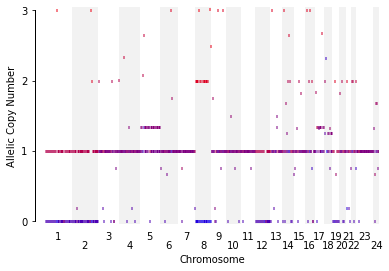

In [29]:
fig, ax = plt.subplots(1,1)

fig = plot_acr_static(default_profile.cnv_profile_df, ax, default_profile.csize, segment_colors='difference', sigmas=False, min_seg_lw=3, y_upper_lim=3)


#### Simulated Coverage/VCF Files

In [ ]:
# Generate TEST binned coverage profile (for WGS)

test_binned_coverage = pd.read_csv('../cnv_data/1Mb.genome_bins.hg38.bed', sep='\t', header=None, names=['chrom', 'start_pos', 'end_pos'])

dispersion_norm = np.random.normal(0, 10, test_binned_coverage.shape[0])
binned_coverage = 30 * (test_binned_coverage['end_pos'] - test_binned_coverage['start_pos'])
# this_chr_coverage = np.asarray([np.random.poisson(cov + np.exp(disp)) for cov, disp in
#                                zip(binned_coverage, dispersion_norm)])  # would need to calculate sum of binned log NP 
this_chr_coverage = np.random.poisson(binned_coverage)
test_binned_coverage['cov'] = this_chr_coverage
test_binned_coverage['chrom'] = test_binned_coverage['chrom'].apply(lambda x: x[3:])
test_binned_coverage.to_csv('./test/simulation/binned_coverage.test', sep='\t', index=False)

In [ ]:
# Generate test VCF file with depth

test_vcf = pd.read_csv('../HapASeg/simulation/NA12878/VCF/NA12878.vcf', sep='\t', comment='#', header=None, 
                     names=['CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT','NA12878'])
test_vcf = test_vcf[['CHROM', 'POS']].rename(columns={'CHROM': 'chr', 'POS': 'pos'})

dispersion_norm = np.random.normal(0, 2, test_vcf.shape[0])
this_chr_coverage = np.asarray([np.random.poisson(30 + np.exp(disp)) for disp in dispersion_norm])
test_vcf['depth'] = this_chr_coverage
test_vcf['chr'] = test_vcf['chr'].apply(lambda x: x[3:])
test_vcf.to_csv('./test/simulation/test_hets.txt', sep='\t', index=False)

### Save Coverage and VCF Files

In [11]:
%%time
# SAVE COVERAGE FILE - WGS

default_profile.save_coverage_file('./test/simulation/NA12878.WGS.genome_test.pur_0_7.txt', 0.7, '../cnv_data/NA12878.WGS.hg38.binned_coverage.bed') #'./test/simulation/binned_coverage.test'


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 1min 11s, sys: 11.6 s, total: 1min 23s
Wall time: 11min 47s


In [17]:
%%time
# SAVE COVERAGE FILE - Pond WES

default_profile.save_coverage_file('./test/simulation/NA12878.WES_Pond.genome_test.pur_0_7.txt', 0.7, '../cnv_data/NA12878.Pond_WES.phase1_2_combined.hg38.binned_coverage.bed') #'./test/simulation/binned_coverage.test'


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 1.67 s, sys: 324 ms, total: 2 s
Wall time: 7.99 s


In [ ]:
%%time
# SAVE COVERAGE FILE - Solexa WES

default_profile.save_coverage_file('./test/simulation/NA12878.Solexa_WES.genome_test.pur_0_7.txt', 0.7, '../cnv_data/NA12878.Solexa_WES.phase1_2_combined.hg38.binned_coverage.bed') #'./test/simulation/binned_coverage.test'


In [ ]:
%%time
# SAVE HETS FILE - WGS
default_profile.save_hets_file('./test/simulation/NA12878.WGS.vcf_depths.genome_test.pur_0_7.txt', '../HapASeg/simulation/NA12878/VCF/NA12878.vcf', '../cnv_data/NA12878_WGS.vcf.depths.bed', 0.7)  # './test/simulation/test_hets.txt'


In [30]:
%%time
# SAVE HETS FILE - Pond WES
default_profile.save_hets_file('./test/simulation/NA12878.Pond_WES.vcf_depths.genome_test.pur_0_7.txt', '../HapASeg/simulation/NA12878/VCF/NA12878.vcf', '../cnv_data/NA12878_Pond_WES.vcf.depths.bed', 0.7)


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 33.9 s, sys: 5.13 s, total: 39 s
Wall time: 4min 55s


In [ ]:
%%time
# SAVE HETS FILE - Solexa WES
default_profile.save_hets_file('./test/simulation/NA12878.Solexa_WES.vcf_depths.genome_test.pur_0_7.txt', '../HapASeg/simulation/NA12878/VCF/NA12878.vcf', '../cnv_data/NA12878_Solexa_WES.vcf.depths.bed', 0.7)

In [59]:
test_hets_file = pd.read_csv('./test/simulation/NA12878.WGS.vcf_depths.genome_test.pur_0_7.txt', sep='\t')
test_hets_file[(test_hets_file['REF_COUNT'] > 10) & (test_hets_file['ALT_COUNT'] > 10)]

,CONTIG,POSITION,REF_COUNT,ALT_COUNT
2,1,740738,24,20
20,1,789680,159,115
22,1,792149,19,20
26,1,797392,23,22
36,1,805514,19,31
...,...,...,...,...
4167762,23,155422097,23,12
4167803,23,155443920,19,24
4167832,23,155522299,16,15
4167844,23,155532668,17,17


## Profile Methods

In [ ]:
from cnv_profile import switch_contigs, get_average_ploidy

In [ ]:
cov_binned = '../cnv_data/NA12878.WGS.hg38.binned_coverage.bed'
x_coverage_df = pd.read_csv(cov_binned, sep='\t', names=['chrom', 'start', 'end', 'coverage', 'cov_adjust'],
                                    dtype={'chrom': str, 'start': int, 'end': int}, header=0)
# change contigs to [0-9]+ from chr[0-9XY]+ in input file
x_coverage_df = switch_contigs(x_coverage_df)
x_coverage_df = x_coverage_df[x_coverage_df['chrom'].isin(default_profile.csize.keys())]
x_coverage_df_test = x_coverage_df.loc[x_coverage_df['chrom'] == '22']

In [ ]:
purity = 0.7

In [42]:
%%timeit
x_coverage_df_test.apply(
    lambda x: get_average_ploidy(default_profile.cnv_trees[x['chrom']], x['start'], x['end'], purity),
    axis=1)

14.6 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%%timeit
x_coverage_df_test.swifter.apply(
    lambda x: get_average_ploidy(default_profile.cnv_trees[str(x['chrom'])], x['start'], x['end'], purity),
    axis=1)

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

16.5 s ± 99.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [51]:
%%timeit
x_coverage_df_test.parallel_apply(
    lambda x: get_average_ploidy(default_profile.cnv_trees[str(x['chrom'])], x['start'], x['end'], purity),
    axis=1)

9.49 s ± 62.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%%timeit
x_coverage_df['cov_adjust'] = np.floor(x_coverage_df['coverage'].values * x_coverage_df['ploidy'].values / 2).astype(int)

217 ms ± 356 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [167]:
start = 6000000
end = 100000000

def single_allele_ploidy(allele, start, end):
    """Get the ploidy for this allele tree over this interval (start, end)."""
    # check genome bins - inclusive or exclusive (how it is now) todo
    intervals = allele.envelop(start, end) | allele[start] | allele[end - 1]
    if len(intervals) == 1:
        return intervals.pop().data[3]
    else:
        interval_totals = [(min(i.end, end) - max(i.begin, start)) * i.data[3] for i in intervals]
        return sum(interval_totals) / (end - start)

def get_average_ploidy_test(tree, start, end, purity):
    # need to run over paternal and maternal alleles

    pat_ploidy = single_allele_ploidy(tree[1], start, end)
    mat_ploidy = single_allele_ploidy(tree[0], start, end)

    return (mat_ploidy + pat_ploidy) * purity + 2 * (1 - purity)

def get_average_ploidy_np(tree, start, end, purity):
    # need to run over paternal and maternal alleles

    pat_ploidy = single_allele_ploidy(tree[1], start, end)
    mat_ploidy = single_allele_ploidy(tree[0], start, end)

    return pat_ploidy, mat_ploidy

def get_average_ploidy_final(pat_ploidy, mat_ploidy, purity):
    """Get the average ploidy defined by the paternal/maternal tumor CN and the purity."""
    return (pat_ploidy + mat_ploidy) * purity + 2 * (1 - purity)

In [142]:
%%timeit
x_coverage_df_test['ploidy'] = x_coverage_df_test.parallel_apply(
    lambda x: get_average_ploidy_test(default_profile.cnv_trees[x['chrom']], x['start'], x['end'], purity),
    axis=1)

<magic-timeit>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8.24 s ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [143]:
%%timeit
x_coverage_df_test[['pat_ploidy', 'mat_ploidy']] = x_coverage_df_test.parallel_apply(
    lambda x: get_average_ploidy_np(default_profile.cnv_trees['22'], x['start'], x['end'], purity),
    axis=1, result_type='expand')

/home/cmesser/.local/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


11.3 s ± 64.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [173]:
%%timeit
x_coverage_df_test['paternal_ploidy'] = x_coverage_df_test.parallel_apply(
    lambda x: single_allele_ploidy(default_profile.cnv_trees[x['chrom']][0], x['start'], x['end']),
    axis=1)
x_coverage_df_test['maternal_ploidy'] = x_coverage_df_test.parallel_apply(
    lambda x: single_allele_ploidy(default_profile.cnv_trees[x['chrom']][1], x['start'], x['end']),
    axis=1)

<magic-timeit>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<magic-timeit>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


11.2 s ± 65.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [172]:
%%timeit
x_coverage_df_test['ploidy'] = get_average_ploidy_final(x_coverage_df_test['paternal_ploidy'].values,
                                             x_coverage_df_test['maternal_ploidy'].values,
                                             purity)

<magic-timeit>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.31 ms ± 51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [144]:
%%timeit
(x_coverage_df_test['mat_ploidy'].values + x_coverage_df_test['pat_ploidy'].values) * purity + 2 * (1 - purity)

443 µs ± 5.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [163]:
%%timeit
x_coverage_df_test['maternal_prop'] = x_coverage_df_test.iloc[1:].parallel_apply(
    lambda x: (default_profile.cnv_trees[x['chrom']][1][x['start']].pop().data.cn_change * purity +
              (1 - purity) ) / x['ploidy'], axis=1)

<magic-timeit>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3.59 s ± 61.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [165]:
%%timeit
x_coverage_df_test['maternal_cn'] = x_coverage_df_test.iloc[1:].parallel_apply(
    lambda x: default_profile.cnv_trees[x['chrom']][1][x['start']].pop().data.cn_change, axis=1)
(x_coverage_df_test['maternal_cn'].values * purity + (1 - purity) ) / x_coverage_df_test['ploidy'].values

<magic-timeit>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3.13 s ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [166]:
%%timeit
(x_coverage_df_test['maternal_cn'].values * purity + (1 - purity) ) / x_coverage_df_test['ploidy'].values

492 µs ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
